<a href="https://colab.research.google.com/github/tonyjosephsebastians/Early-Fire-Detetcion/blob/main/fire_detection_in_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Detection in Images

**Description about the dataset:**

Data was gathered to train a model to differentiate between photographs of fire and other types of imagery (non-fire images). Data is separated into 2 files, one of which, called non-fireimages, has images of nature and the other, called fireimages, contains photographs of outdoor fires, some of which involve significant smoke (eg: forest, tree, grass, river, people, foggy forest, lake, animal, road, and waterfall).

**Objective: To create a classification model that can detect fire in images**

**Models used: Sequential CNN from scratch, Pretrained Xception with modifications**

## Exploratory Data Analysis

In [ ]:
#!pip install plotly
#!pip install tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

sns.set_style('darkgrid')

**Let's first create a dataframe that contains the path to each picture and its corresponding label (fire or non fire).**

**Reading Paths**

In [ ]:

#create an empty DataFrame
df = pd.DataFrame(columns=['path','label'])

#loop over fire images and label them 1
for dirname, _, filenames in os.walk('C:/Users/jcp95/OneDrive/Desktop/Fire/data/fire_dataset/fire_images'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

#loop over non fire images and label them 0
for dirname, _, filenames in os.walk('C:/Users/jcp95/OneDrive/Desktop/Fire/data/fire_dataset/non_fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
        #print(os.path.join(dirname, filename))

#shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

In [ ]:
fig = px.scatter(data_frame = df,x=df.index,y='label',color='label',title='Distribution of fire and non-fire images along the length of the dataframe')
fig.update_traces(marker_size=2)

**we shuffled the data.**

**Now lets visualise the dataset**

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])


fig.add_trace(go.Bar(x =df['label'].value_counts().index,y=df['label'].value_counts().to_numpy(),marker_color=['skyblue','green'],showlegend=False),row=1,col=1)

fig.add_trace(go.Pie(
     values=df['label'].value_counts().to_numpy(),
     labels=df['label'].value_counts().index,
    marker=dict(colors=['blue','orange'])),
    row=1, col=2)


**Non fire label has less number of images. The dataset is imbalanced**

## Visualizing the images with fire

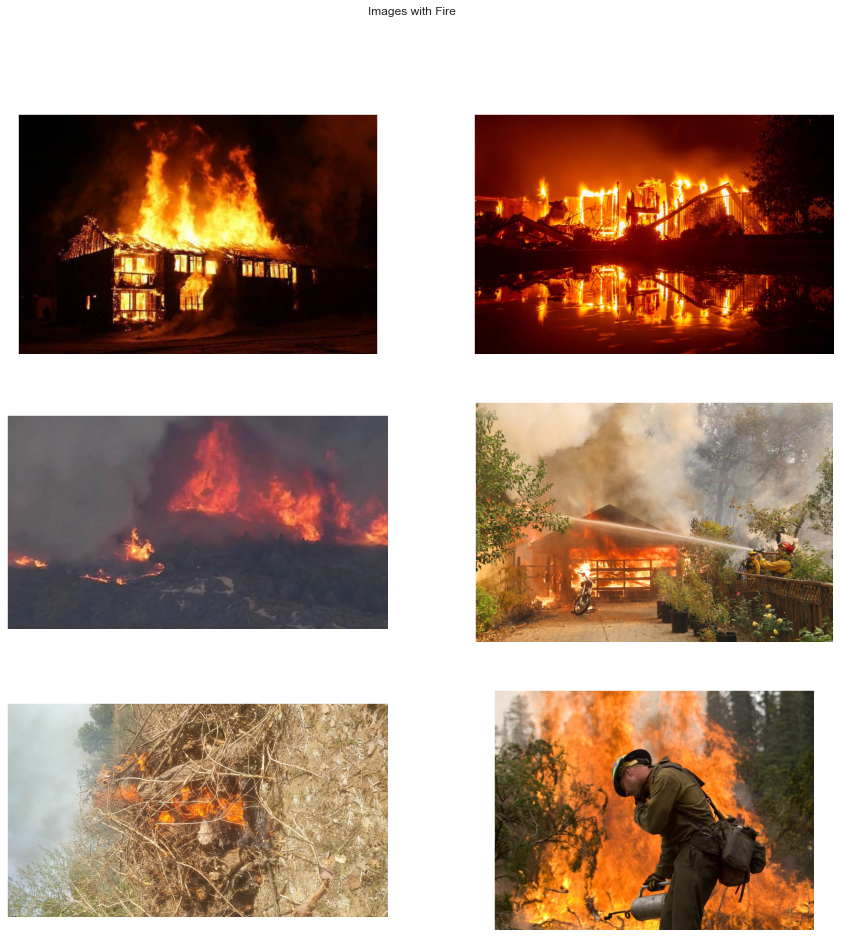

In [ ]:
label = 'fire' #label for images with fire
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

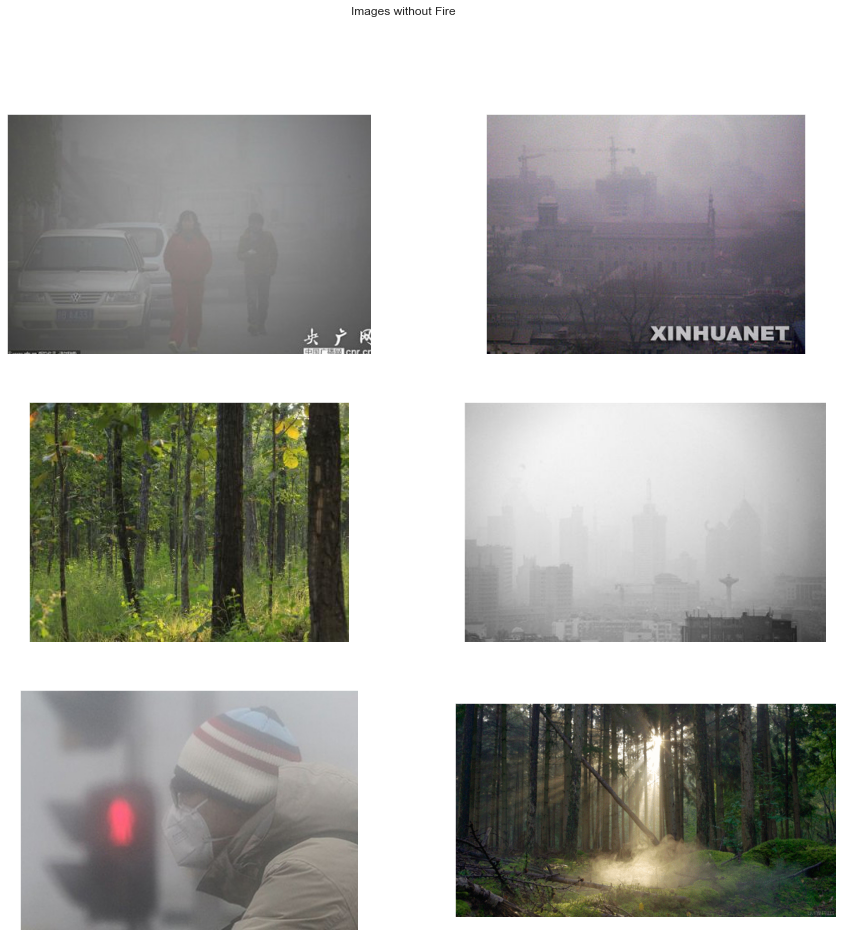

In [ ]:
label = 'non_fire' #label for images without fire
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images without Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

**As you can see, the sizes of the images are different. Let's visualize the distribution of their shapes**

In [ ]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

,path,label,height,width
0,C:/Users/jcp95/OneDrive/Desktop/Fire/data/fire...,non_fire,2055,3000
1,C:/Users/jcp95/OneDrive/Desktop/Fire/data/fire...,non_fire,438,778
2,C:/Users/jcp95/OneDrive/Desktop/Fire/data/fire...,non_fire,300,400
3,C:/Users/jcp95/OneDrive/Desktop/Fire/data/fire...,non_fire,1733,2600
4,C:/Users/jcp95/OneDrive/Desktop/Fire/data/fire...,fire,3824,5737


## Visualizing Shape Distribution

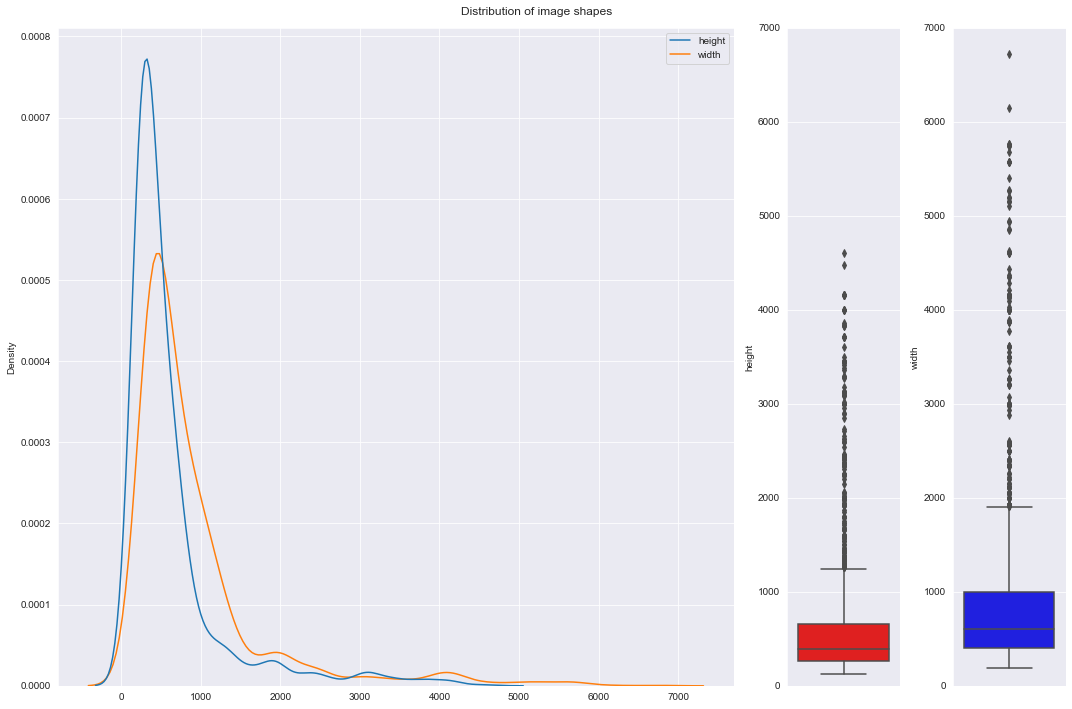

In [ ]:
sns.set_style('darkgrid')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios': [3,0.5,0.5]},figsize=(15,10))
sns.kdeplot(data=df.drop(columns=['path','label']),ax=ax1,legend=True)
sns.boxplot(data=df,y='height',ax=ax2,color='red')
sns.boxplot(data=df,y='width',ax=ax3,color='blue')
plt.suptitle('Distribution of image shapes')
ax3.set_ylim(0,7000)
ax2.set_ylim(0,7000)
plt.tight_layout()

## Image Generation or Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

**Creating the training and test generator**

**We used the flow_from_dataframe method of the ImageDataGenerator class. It will take the path of the images from the dataframe along with their labels. We construct two generators, one for training and the other for validation.**

In [ ]:
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 1560 validated image filenames belonging to 2 classes.
Found 390 validated image filenames belonging to 2 classes.


#### Class indices assigned by the Image generator

In [ ]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)

{0: 'fire', 1: 'non_fire'}


**Hence an image predicted 0 will contain fire and 1 won't.**

## Visualizing the generated images in training set

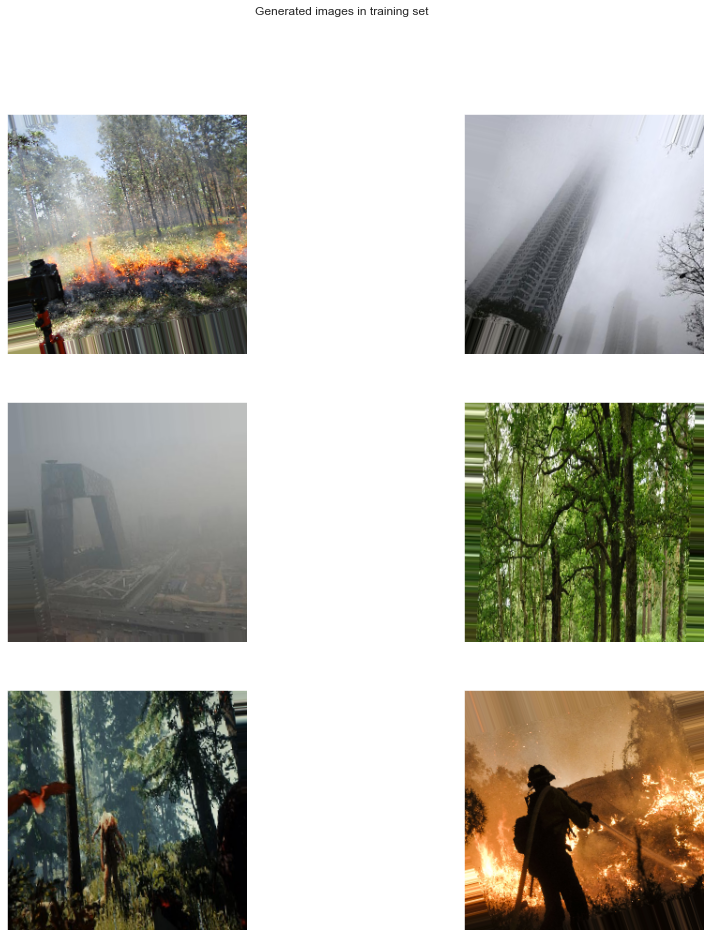

In [ ]:
sns.set_style('dark')
pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Generated images in training set')
ax = ax.ravel()
for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

## Creating the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

**We increase the number of filters as we add more layers because initially there will be a lot of noise present in the input and we only need to capture the important information. Later as we progress through the layers, the feature maps become nuanced and we try to capture them with more filters**  

### Model Summary

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 31, 31, 128)     

**Compiling the model**

In [ ]:
from tensorflow.keras.metrics import Recall,AUC
from tensorflow.keras.utils import plot_model

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

**Defining Callbacks**


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

### Model Fitting

In [ ]:
model.fit(x=train_gen,batch_size=32,epochs=50,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])

Epoch 1/15
49/49 [==============================] - 102s 2s/step - loss: 0.3603 - accuracy: 0.8513 - recall_4: 0.9158 - auc_4: 0.9156 - val_loss: 0.2042 - val_accuracy: 0.9205 - val_recall_4: 0.9951 - val_auc_4: 0.9722 - lr: 0.0010
Epoch 2/15
49/49 [==============================] - 98s 2s/step - loss: 0.1823 - accuracy: 0.9340 - recall_4: 0.9630 - auc_4: 0.9783 - val_loss: 0.1813 - val_accuracy: 0.9462 - val_recall_4: 0.9902 - val_auc_4: 0.9796 - lr: 0.0010
Epoch 3/15
49/49 [==============================] - 102s 2s/step - loss: 0.1630 - accuracy: 0.9417 - recall_4: 0.9663 - auc_4: 0.9787 - val_loss: 0.2078 - val_accuracy: 0.9436 - val_recall_4: 0.9804 - val_auc_4: 0.9732 - lr: 0.0010
Epoch 4/15
49/49 [==============================] - 96s 2s/step - loss: 0.1737 - accuracy: 0.9397 - recall_4: 0.9596 - auc_4: 0.9796 - val_loss: 0.1478 - val_accuracy: 0.9333 - val_recall_4: 0.9510 - val_auc_4: 0.9864 - lr: 0.0010
Epoch 5/15
49/49 [==============================] - 101s 2s/step - loss: 0

KeyboardInterrupt: 

### Model Evaluation

**Plotting metrics**

In [ ]:
history= model.history.history
px.line(history,title = "Metrics Plot")

In [ ]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

13/13 [==============================] - 11s 845ms/step - loss: 0.1223 - accuracy: 0.9462 - recall_1: 0.9585 - auc_1: 0.9922
loss: 0.12
accuracy: 0.95
recall_1: 0.96
auc_1: 0.99


### Model trained with same parameters with different patience

In [ ]:
early_stoppping = EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=10)

In [ ]:
model.fit(x=train_gen,batch_size=32,epochs=100,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])

## Model creation by transfer learning

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

In [ ]:
xception = Xception(include_top = False,input_shape = (256,256,3))
input_to_model = xception.input
#turn off training
xception.trainable = False

x = Flatten()(xception.output)
x = Dense(64,activation = 'relu')(x)
output_to_model = Dense(1,activation = 'sigmoid')(x)
model2 = Model(inputs = input_to_model,outputs = output_to_model)

**Compiling the model**

In [ ]:
model2.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy',Recall(),AUC()])

**Fitting the model**

In [ ]:
history2 = model2.fit(x = train_gen,batch_size=32,epochs=15,callbacks = [early_stoppping,reduce_lr_on_plateau],validation_data = val_gen)

Epoch 1/15
49/49 [==============================] - 238s 5s/step - loss: 0.9535 - accuracy: 0.8769 - recall_2: 0.8918 - auc_2: 0.9185 - val_loss: 0.2309 - val_accuracy: 0.9538 - val_recall_2: 0.9770 - val_auc_2: 0.9770 - lr: 0.0010
Epoch 2/15
49/49 [==============================] - 231s 5s/step - loss: 0.1165 - accuracy: 0.9660 - recall_2: 0.9670 - auc_2: 0.9915 - val_loss: 0.1708 - val_accuracy: 0.9641 - val_recall_2: 0.9908 - val_auc_2: 0.9843 - lr: 0.0010
Epoch 3/15
49/49 [==============================] - 235s 5s/step - loss: 0.0733 - accuracy: 0.9724 - recall_2: 0.9761 - auc_2: 0.9970 - val_loss: 0.2115 - val_accuracy: 0.9513 - val_recall_2: 0.9954 - val_auc_2: 0.9775 - lr: 0.0010
Epoch 4/15
49/49 [==============================] - 232s 5s/step - loss: 0.0782 - accuracy: 0.9750 - recall_2: 0.9761 - auc_2: 0.9955 - val_loss: 0.1230 - val_accuracy: 0.9538 - val_recall_2: 0.9539 - val_auc_2: 0.9899 - lr: 0.0010
Epoch 5/15
49/49 [==============================] - 233s 5s/step - loss:

### Model Evaluation

In [ ]:
px.line(history,title='Metrics Plot')

In [ ]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

13/13 [==============================] - 12s 891ms/step - loss: 0.1215 - accuracy: 0.9487 - recall_1: 0.9724 - auc_1: 0.9916
loss: 0.12
accuracy: 0.95
recall_1: 0.97
auc_1: 0.99


## Example Prediction

**Let's use an image of the apartment complex in Texas that caught fire in February 2021.**

News link : https://www.nytimes.com/2021/02/19/us/san-antonio-fire-hydrants-water.html

In [ ]:
#Downloading the image
!curl https://static01.nyt.com/images/2021/02/19/world/19storm-briefing-texas-fire/19storm-briefing-texas-fire-articleLarge.jpg --output predict.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 50241  100 50241    0     0   498k      0 --:--:-- --:--:-- --:--:--  505k


**Printing the image**

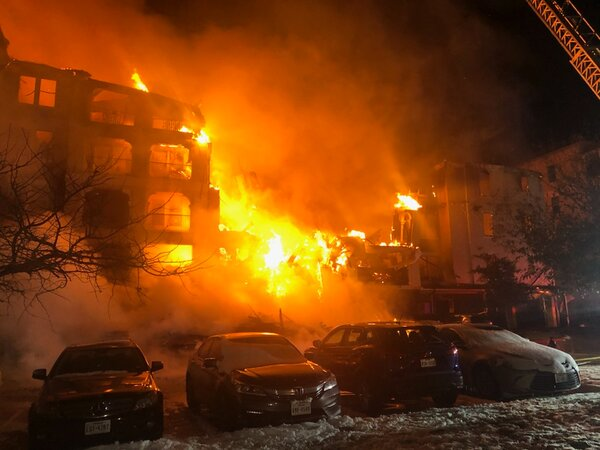

In [ ]:
#loading the image
img = image.load_img('predict.jpg')
img

**Resizing the image and expanding its dimension to include the batch size - 1**

In [ ]:
img = image.img_to_array(img)/255
img = tf.image.resize(img,(256,256))
img = tf.expand_dims(img,axis=0)

print("Image Shape",img.shape)

Image Shape (1, 256, 256, 3)


**Prediction**

In [ ]:
prediction = int(tf.round(model2.predict(x=img)).numpy()[0][0])
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

1/1 [==============================] - 0s 315ms/step
The predicted value is:  0 and the predicted label is: fire
